In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import *
import os


from scipy.linalg import lstsq
# lmfit is a great library, it is a wrapper around scipy.optimize.minimize and curve_fit with many other stuff
from lmfit import Parameters, report_fit, Minimizer

In [4]:
# this is our A->B->C model, since the k1 can be equal to k2 during fitting, we have to define also model model for k1=k2, the equation for it is different,
# othervise, we would get zero division errors. This process can be avoided by numerical integration, which is convenient for more complicated models
def calc_C(k1, k2, times, c0=1):
    diff = 1e-8
    C = np.empty((times.shape[0], 3))
    C[:, 0] = c0 * np.exp(-k1 * times)  # [A] = c0 * exp(-k1 * t)
    if np.abs(k1 - k2) < diff:  # k1 == k2
        C[:, 1] = c0 * k1 * times * np.exp(-k1 * times)  # [B] = c0 * k1 * t * exp(-k1 * t)
    else:
        C[:, 1] = c0 * (k1 / (k2 - k1)) * (np.exp(-k1 * times) - np.exp(-k2 * times))  # [B] = c0 * (k1 / (k2 - k1)) * (exp(-k1 * t) - exp(-k2 * t))
    C[:, 2] = c0 - C[:, 0] - C[:, 1]  # [C] = c0 - [A] - [B]
    return C

def db_exp(k1, k2, times):
    return calc_C(k1, k2, times, 1)[:, 1]

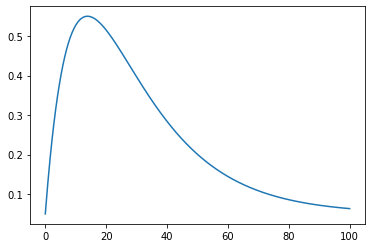

In [73]:
times = np.linspace(0, 100, 500)

# C = calc_C(0.1, 0.05, times)

y_real = db_exp(0.1, 0.05, times) + 0.05

plt.plot(times, y_real)
plt.show()

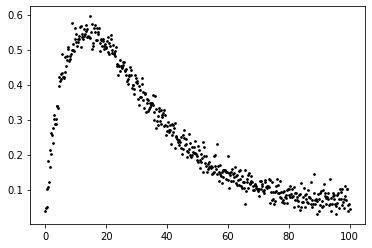

In [74]:
y_noise = np.random.normal(y_real, scale=0.02)
plt.scatter(times, y_noise, s=3, color='k')
plt.show()

In [182]:
params = Parameters()
params.add('k1', value=1, min=0, vary=True)
params.add('k2', value=1, min=0, vary=True)
params.add('y0', value=0.1, vary=True)


simulate = lambda params: db_exp(params['k1'].value, params['k2'].value, times) + params['y0'].value
simulate_v = lambda vals: db_exp(vals[0], vals[1], times) + vals[2]

history = []

def callback(params, i, resid, *args, **kws):
    
    k1, k2, y0 = params['k1'].value, params['k2'].value, params['y0'].value
    
    now = np.asarray([k1, k2, y0])
    
    if len(history) == 0:
        history.append(now)
        return False
    
    changes = np.abs(now / history[-1])
    changes[changes < 1] = 1 / changes[changes < 1]
    
    if any(changes[changes > 1 + 1e-1]):
        history.append(now)
        
    return False

def residuals(params):
    y_fit = simulate(params)
    return y_noise - y_fit

m = Minimizer(residuals, params, iter_cb=callback)

result = m.minimize(method='least_squares', verbose=2)

history = np.asarray(history)

result.params


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2443e+01                                    6.83e+01    
       1              2         6.9717e+00      5.47e+00       9.62e-01       1.32e+00    
       2              3         6.3081e+00      6.64e-01       7.70e-01       9.65e+00    
       3              6         6.1770e+00      1.31e-01       3.63e-02       8.53e-01    
       4              7         6.1435e+00      3.35e-02       3.48e-02       8.88e-01    
       5              8         6.0704e+00      7.31e-02       6.89e-02       9.61e-01    
       6              9         5.8921e+00      1.78e-01       1.33e-01       1.20e+00    
       7             10         5.3121e+00      5.80e-01       2.44e-01       1.68e+00    
       8             11         4.7220e+00      5.90e-01       3.74e-01       1.12e+02    
       9             12         1.8722e+00      2.85e+00       1.08e-01       2.04e+01    

name,value,standard error,relative error,initial value,min,max,vary
k1,0.10055718,9.7773e-04,(0.97%),1,0.00000000,inf,True
k2,0.05084293,5.3290e-04,(1.05%),1,0.00000000,inf,True
y0,0.05271954,0.00215060,(4.08%),0.1,-inf,inf,True


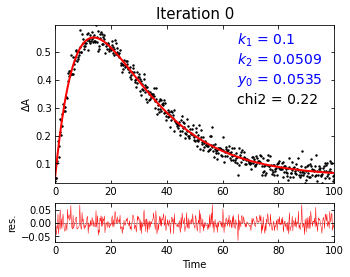

In [173]:
def _set_main_axis(ax, x_label='', y_label="Absorbance", xlim=(None, None), ylim=(None, None),
                  x_major_locator=None, x_minor_locator=None, y_major_locator=None, y_minor_locator=None):
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    if xlim[0] is not None:
        ax.set_xlim(xlim)
    if ylim[0] is not None:
        ax.set_ylim(ylim)

    if x_major_locator:
        ax.xaxis.set_major_locator(x_major_locator)

    if x_minor_locator:
        ax.xaxis.set_minor_locator(x_minor_locator)

    if y_major_locator:
        ax.yaxis.set_major_locator(y_major_locator)

    if y_minor_locator:
        ax.yaxis.set_minor_locator(y_minor_locator)

    ax.tick_params(axis='both', which='major', direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')

def plot_fit(x, y_data, y_fit, lw_res=0.5, lw_fit=2, fig_size=(5, 4), y_label='$\\Delta$A', x_label='Time',
                  x_lim=(None, None), y_lim=(None, None), filepath=None, dpi=500, transparent=False,
             x_major_locator=None, y_major_locator=None, data_color='black', s=2, iteration=0, vals=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size, gridspec_kw={'height_ratios': (4, 1)})

    _x_lim = list(x_lim)
    _y_lim = list(y_lim)

    _x_lim[0] = x[0] if _x_lim[0] is None else _x_lim[0]
    _x_lim[1] = x[-1] if _x_lim[1] is None else _x_lim[1]

    _y_lim[0] = y_data.min() if _y_lim[0] is None else _y_lim[0]
    _y_lim[1] = y_data.max() if _y_lim[1] is None else _y_lim[1]

    _set_main_axis(ax1, x_label="", y_label=y_label, xlim=_x_lim, ylim=_y_lim, x_major_locator=x_major_locator,
                   y_major_locator=y_major_locator)
    _set_main_axis(ax2, x_label=x_label, y_label='res.', xlim=_x_lim, x_minor_locator=None, y_minor_locator=None)

    # plot zero lines
    ax1.axline((0, 0), slope=0, ls='--', color='black', lw=0.5)
    ax2.axline((0, 0), slope=0, ls='--', color='black', lw=0.5)

    ax1.scatter(x, y_data, color=data_color, s=s)
    ax1.plot(x, y_fit, lw=lw_fit, color='red')
    ax2.plot(x, y_data - y_fit, lw=lw_res, color='red')
    
    r = y_data - y_fit
    chi2 = (r ** 2).sum()
    
    ax1.text(0.65, 0.63, f'$k_1$ = {vals[0]:.3g}\n$k_2$ = {vals[1]:.3g}\n$y_0$ = {vals[2]:.3g}', transform=ax1.transAxes, fontsize=14, color='blue')
    ax1.text(0.65, 0.5, f'chi2 = {chi2:.2g}', transform=ax1.transAxes, fontsize=14, color='black')

    ax1.set_title(f'Iteration {iteration}', fontsize=15)

    ax1.set_axisbelow(False)
    ax2.set_axisbelow(False)

    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')

    ax2.yaxis.set_ticks_position('both')
    ax2.xaxis.set_ticks_position('both')

#     fig.tight_layout()

    if filepath:
        ext = os.path.splitext(filepath)[1].lower()[1:]
        plt.savefig(fname=filepath, format=ext, transparent=transparent, dpi=dpi)
        return

    plt.show()


def plot_iteration(i):
    y_fit = simulate_v(history[i])
    plot_fit(times, y_noise, y_fit, iteration=i+1, vals=history[i])
    
%matplotlib inline
plot_iteration(-1)

In [174]:
%matplotlib 

_dir = "animations\\trace fit"

for i in range(len(history)):
    fname = f"{_dir}\\{i:03d}.png"
    y_fit = simulate_v(history[i])
    plot_fit(times, y_noise, y_fit, iteration=i+1, vals=history[i], filepath=fname, transparent=False)
    


Using matplotlib backend: Qt5Agg


In [181]:
delay = 50
delay_last = 500  # https://stackoverflow.com/questions/40191000/imagemagick-convert-command-set-delay-time-for-the-last-frame
# files = " ".join(f"\"{_dir}\\{i:03d}.png\"" for i in range(13))
files = " ".join(f"{i:03d}.png" for i in range(13))
# command = f"magick convert -dispose previous -loop 0 -delay {delay} {files} -delay {500} \"{_dir}\\013.png\" \"{_dir}\\out.gif\""
command = f"magick convert -dispose previous -loop 0 -delay {delay} {files} -delay 500 013.png out.gif"

# os.popen(command)
command

'magick convert -dispose previous -loop 0 -delay 100 000.png 001.png 002.png 003.png 004.png 005.png 006.png 007.png 008.png 009.png 010.png 011.png 012.png -delay 500 013.png out.gif'

## Global fit example

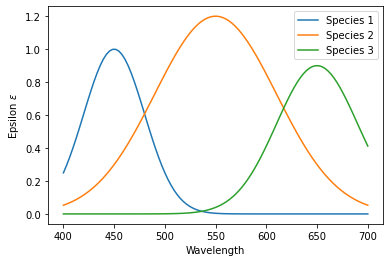

In [5]:
%matplotlib inline

times = np.linspace(0, 100, 100)  # linear space of times from 0 to 499 in arbitrary units
wavelengths = np.linspace(400, 700, 100)  # linear space of wavelengths from 300 to 599 in arbitrary units

n = 3

ST = np.zeros((n, wavelengths.shape[0]))  # define epsilon matrix with dimensions n x w

# define gaussian function (without a scaling factor) for creating sample spectra
def gauss(x, mu, sigma):
    return np.exp(- (x - mu) * (x - mu) / (2 * sigma * sigma))

# fill epsilon matrix for all 3 species with generated spectra by gaussian function
ST[0] = gauss(wavelengths, 450, 30)
ST[1] = 1.2 * gauss(wavelengths, 550, 60)
ST[2] = 0.9 * gauss(wavelengths, 650, 40)

plt.rcParams['figure.figsize'] = [6, 4]
for i in range(n):
    plt.plot(wavelengths, ST[i], label='Species {}'.format(i+1))
plt.xlabel('Wavelength')
plt.ylabel('Epsilon $\epsilon$')
plt.legend()
plt.savefig(fname='spectra.png', format='png', transparent=False, dpi=300)
plt.show()

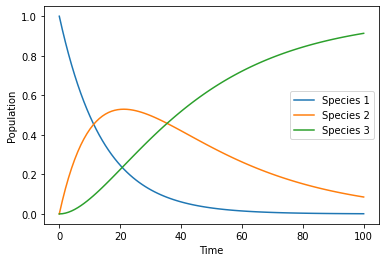

In [6]:
C = calc_C(0.07, 0.03, times)

for i in range(n):
    plt.plot(times, C[:, i], label='Species {}'.format(i+1))
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.savefig(fname='profiles.png', format='png', transparent=False, dpi=300)
plt.show()


In [7]:
D = C @ ST
D.shape

D_noise = np.random.normal(D, scale=0.03)

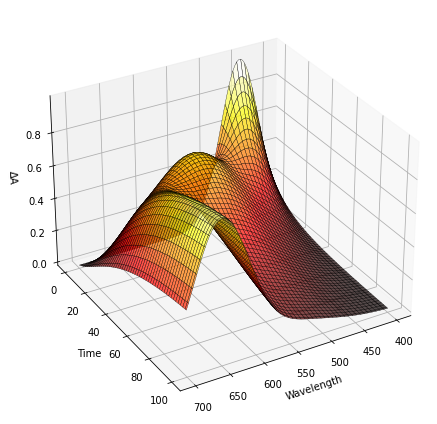

In [153]:
%matplotlib inline

def plot_3d(D_fit, azim=0, filepath=None, transparent=False, dpi=200, vals=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    x, y = np.meshgrid(wavelengths, times)

    ax.plot_surface(x, y, D_fit, antialiased=True,  cmap='hot', alpha=0.7, rstride=2, cstride=2, edgecolors='black', lw=0.3)

    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Time")
    ax.set_zlabel("$\\Delta$A")
#     ax.set_title("Data")
    
    ax.view_init(elev=30., azim=azim)

    # plt.legend()
    fig.tight_layout()
    
    if filepath:
        ext = os.path.splitext(filepath)[1].lower()[1:]
        fig.savefig(fname=filepath, format=ext, transparent=transparent, dpi=dpi)
        return
    
#     plt.show()
#     plt.close()
    
    
plot_3d(D, azim=60)


In [ ]:
_dir = "animations\\data_3d"

for i in range(0, 360, 1):
    fname = f"{_dir}\\{i:03d}.png"
    plot_3d(D, azim=i, filepath=fname)

In [133]:
from scipy.linalg import lstsq

params = Parameters()
params.add('k1', value=1, min=0, vary=True)
params.add('k2', value=0.1, min=0, vary=True)

# simulate = lambda params: db_exp(params['k1'].value, params['k2'].value, times) + params['y0'].value
# simulate_v = lambda vals: db_exp(vals[0], vals[1], times) + vals[2]

# calc_ST = lambda C: lstsq(C, D_noise)[0]

def simulate_from_v(vals):
    C = calc_C(vals[0], vals[1], times)
    ST = lstsq(C.copy(), D_noise.copy(), lapack_driver='gelsy')[0]
    return C @ ST
    
history = []

def callback(params, i, resid, *args, **kws):
    
    k1, k2 = params['k1'].value, params['k2'].value
    
    now = np.asarray([k1, k2])
    
    if len(history) == 0:
        history.append(now)
        return False
    
    changes = np.abs(now / history[-1])
    changes[changes < 1] = 1 / changes[changes < 1]
    
    if any(changes[changes > 1 + 1e-1]):
        history.append(now)
        
    return False

def residuals(params):
    D_fit = simulate_from_v((params['k1'].value, params['k2'].value))
    return D_noise - D_fit

m = Minimizer(residuals, params, iter_cb=callback)

result = m.minimize(method='least_squares', verbose=2)

history = np.asarray(history)

result.params


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1556e+01                                    3.78e+01    
       1              2         4.2756e+01      1.88e+01       2.63e-01       3.11e+01    
       2              3         2.7692e+01      1.51e+01       2.64e-01       1.89e+01    
       3              4         1.5894e+01      1.18e+01       1.97e-01       1.37e+01    
       4              5         7.9028e+00      7.99e+00       1.18e-01       9.58e+00    
       5              6         4.9407e+00      2.96e+00       5.83e-02       3.08e+00    
       6              7         4.4926e+00      4.48e-01       2.49e-02       1.24e+01    
       7              8         4.4554e+00      3.72e-02       8.76e-03       3.15e+00    
       8              9         4.4545e+00      9.21e-04       1.25e-03       6.12e-02    
       9             10         4.4545e+00      4.36e-07       3.08e-05       1.79e-05    

name,value,standard error,relative error,initial value,min,max,vary
k1,0.07034152,0.00112818,(1.60%),1,0.00000000,inf,True
k2,0.03072596,6.1990e-04,(2.02%),0.1,0.00000000,inf,True


In [142]:
%matplotlib qt

def plot_3d_data(D_fit=None, azim=50, filepath=None, transparent=False, dpi=300, vals=None, iteration=0):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    x, y = np.meshgrid(wavelengths, times)

    ax.scatter(x, y, D_noise, s=0.5, cmap='hot', c=D_noise, alpha=0.5)
    ax.plot_surface(x, y, D_fit, antialiased=True, color='black', alpha=0.3, rstride=1, cstride=1, edgecolors='None')
    
    r = D_noise - D_fit
    chi2 = (r ** 2).sum()
    
    ax.text(300, 0, 0, f'$k_1$ = {vals[0]:.3g}\n$k_2$ = {vals[1]:.3g}', fontsize=14, color='blue')
    ax.text(700, 0, 1, f'chi2 = {chi2:.3g}', fontsize=14, color='black')

    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Time")
    ax.set_zlabel("$\\Delta$A")
    ax.set_title(f"Iteration {iteration}")
    
    ax.set_xlim(400, 700)
    ax.set_zlim(0, 1)

    
    ax.view_init(elev=30., azim=azim)

    # plt.legend()
    fig.tight_layout()
    
    if filepath:
        ext = os.path.splitext(filepath)[1].lower()[1:]
        fig.savefig(fname=filepath, format=ext, transparent=transparent, dpi=dpi)
        return
    plt.show()

    
def plot_iteration(i):
    D_fit = simulate_from_v(history[i])
    plot_3d_data(D_fit, vals=history[i], iteration=i+1)
    
    
plot_iteration(2)

In [138]:
history

array([[1.        , 0.1       ],
       [0.7393355 , 0.06254853],
       [0.47616364, 0.04140198],
       [0.27971134, 0.02921316],
       [0.16197466, 0.02283415],
       [0.10367889, 0.02160843],
       [0.07914242, 0.02596316],
       [0.07132478, 0.0299071 ]])

In [144]:
%matplotlib inline

_dir = "animations\\global_fit"

for i in range(len(history)):
    fname = f"{_dir}\\{i:03d}.png"
    D_fit = simulate_from_v(history[i])
    plot_3d_data(D_fit, iteration=i+1, vals=history[i], filepath=fname, transparent=False)


In [147]:
delay = 70
delay_last = 500  # https://stackoverflow.com/questions/40191000/imagemagick-convert-command-set-delay-time-for-the-last-frame
files = " ".join(f"\"{_dir}\\{i:03d}.png\"" for i in range(7))
# files = " ".join(f"{i:03d}.png" for i in range(7))
# command = f"magick convert -dispose previous -loop 0 -delay {delay} {files} -delay {500} \"{_dir}\\013.png\" \"{_dir}\\out.gif\""
command = f"magick convert -dispose previous -loop 0 -delay {delay} {files} -delay 500 \"{_dir}\\007.png\" \"{_dir}\\out.gif\""

os.popen(command)
# command